## Relation of Variance and Predictive Error CPL
Author: Clara Hoffmann

In [1]:
# load packages
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from helpers import (Fy, find_closest_element, error_vs_variance)
from density_predictor_class_val import density_predictor

In [2]:
# read in val data
B_zeta = np.load('../../../../data/commaai/extracted_coefficients/copula_cil/Bzeta/B_zeta_val.npy')
beta = np.genfromtxt('../../../../data/commaai/extracted_coefficients/copula_cil/beta/beta.csv', delimiter = ',')
#B_zeta = B_zeta.reshape(B_zeta.shape[0], B_zeta.shape[])
true_y = np.load('../../../../data/commaai/extracted_coefficients/copula_cil/Bzeta/labels_val.npy')
true_z = np.load('../../../../data/commaai/extracted_coefficients/copula_cil/Bzeta/tr_labels_val.npy')

B_zeta = B_zeta[np.abs(true_y) < 40,:] 
true_z = true_z[np.abs(true_y) < 40]
true_y = true_y[np.abs(true_y) < 40]

density_path = '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

no_points = 1000
# grid for variances
grid = np.linspace(0,500,500)

In [3]:
# predict densities
dens = density_predictor(B_zeta, true_y, density, no_points)
result_va_ridge = dens.get_density('va_ridge')
#result_hmc_ridge = dens.get_density('hmc_ridge')
result_va_horse = dens.get_density('va_horseshoe')
#result_hmc_horse = dens.get_density('hmc_horseshoe')

  0%|          | 81/94570 [00:00<01:57, 804.95it/s]

computing densities for each observation


  1%|▏         | 1320/94570 [00:00<00:07, 13198.31it/s]

computing mean prediction for each observation


  3%|▎         | 2682/94570 [00:00<00:06, 13423.88it/s]

computing variance prediction for each observation


100%|██████████| 94570/94570 [00:06<00:00, 13553.08it/s]


In [4]:
x1 = np.load('../../../../data/commaai/predictions/mc_preds_cil_1_neu.npy').reshape(-1,1000)
x2 = np.load('../../../../data/commaai/predictions/mc_preds_cil_2_neu.npy').reshape(-1,1000)
x3 = np.load('../../../../data/commaai/predictions/mc_preds_cil_3_neu.npy').reshape(-1,1000)
x4 = np.load('../../../../data/commaai/predictions/mc_preds_cil_4_neu.npy').reshape(-1,1000)

mc_preds = np.append(np.append(np.append(x1, x2, axis = 0), x3, axis = 0), x4, axis = 0)
mc_var = np.std(mc_preds, axis = 1)**2
mc_mean = np.mean(mc_preds, axis = 1)
results_mc = pd.DataFrame({'mean prediction': mc_mean.reshape(-1),
                          'variance prediction': mc_var.reshape(-1)})

In [5]:
mdn_preds = np.load('../../../../data/commaai/predictions/mdn/cil/samples.npy')
mdn_var = np.std(mdn_preds, axis = 1)**2
mdn_mean = np.mean(mdn_preds, axis = 1)
results_mdn = pd.DataFrame({'mean prediction': mdn_mean.reshape(-1),
                          'variance prediction': mdn_var.reshape(-1)})

In [6]:
# mse of predictions given grid (= variance) value
er_conf_va_ridge = error_vs_variance(result_va_ridge, grid, true_y)
#er_conf_hmc_ridge = error_vs_variance(result_hmc_ridge, grid, true_y)
er_conf_va_horse = error_vs_variance(result_va_horse, grid, true_y)
#er_conf_hmc_horse = error_vs_variance(result_hmc_horse, grid, true_y)
er_conf_mc = error_vs_variance(results_mc, grid, true_y)
er_conf_mdn = error_vs_variance(results_mdn, grid, true_y)

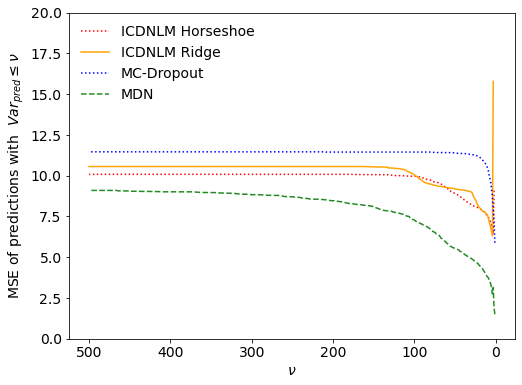

In [7]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(4,3))
#plt.plot(grid, er_conf_hmc_ridge, label = 'HMC/Ridge', color = 'darkorange')
plt.plot(grid, er_conf_va_horse, label = 'IC-NLM Horseshoe', color = 'red', linestyle = 'dotted')
#plt.plot(grid, er_conf_hmc_horse, label = 'HMC/Horseshoe', color = 'darkred', linestyle = 'dashed')
plt.plot(grid, er_conf_va_ridge, label = 'IC-NLM Ridge', color = 'orange')
plt.plot(grid, er_conf_mc, label = 'MC-Dropout', color = 'blue', linestyle = ':')
plt.plot(grid, er_conf_mdn, label = 'MDN', color = 'forestgreen', linestyle = '--')
plt.legend()
plt.legend(framealpha=0.0)
plt.ylim(0,20)
plt.gca().invert_xaxis()
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.xlabel(r'$\nu$')
plt.ylabel(r'MSE of predictions with  $Var_{pred} \leq \nu$')
plt.savefig('error_vs_confidence_cil.png', dpi = 100, bbox_inches='tight')

In [ ]:
#plt.scatter(result_hmc_horse['mean prediction'], result_hmc_horse['variance prediction'], alpha = 0.1, color = 'darkred', label = 'HMC/VA Horseshoe')
#plt.scatter(result_hmc_ridge['mean prediction'], result_hmc_ridge['variance prediction'], alpha = 0.1, color = 'orange', label = 'HMC/VA Ridge')
plt.scatter(result_va_ridge['mean prediction'], result_va_ridge['variance prediction'], alpha = 0.1, color = 'orange', label = 'HMC/VA Ridge')
plt.scatter(results_mc['mean prediction'], results_mc['variance prediction'], alpha = 0.1, color = 'blue', label = 'MC-Dropout')
plt.legend()
plt.legend(framealpha=0.0)
#for lh in leg.legendHandles: 
#    lh._legmarker.set_alpha(1)
#    lh._legmarker.set_framealpha(0.0)
plt.legend(framealpha=0.0)
plt.ylim(0,200)
plt.xlabel('steering angle in degrees')
plt.ylabel('predicted variance')
#plt.savefig('mean_vs_var_cil.png')

In [ ]:
plt.scatter(np.abs(true_y - result_va_ridge['mean prediction']), result_va_ridge['variance prediction'],  alpha = 0.1, color = 'orange', label = 'HMC/VA Ridge')

In [ ]:
plt.scatter(np.abs(true_y - results_mc['mean prediction']),results_mc['variance prediction'], alpha = 0.1, color = 'orange', label = 'HMC/VA Ridge')

In [ ]:
plt.scatter(true_y, result_va_ridge['mean prediction'],alpha = 0.1)
plt.scatter(true_y, results_mc['mean prediction'],alpha = 0.1)